In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import datetime

import imageio
from skimage.measure import block_reduce

In [2]:
patch_size = 16
nb_channels = 3

batch_size = 32

In [3]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'

train_data_dir      = base_dir + '/tiny_train16'
validation_data_dir = base_dir + '/tiny_validation16'
test_data_dir       = base_dir + '/tiny_test16'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 16x16
        patches_out -- tensor of the original patches downsampled to 8x8
    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = block_reduce(patch_in, (2, 2, 1), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
#     patches_in = np.expand_dims(patches_in, -1)  # need this if grayscale
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
#     patches_out = np.expand_dims(patches_out, -1)  # need this if grayscale
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir)
x_validation, y_validation = loading_data(validation_data_dir)

in (157086, 16, 16, 3) ; out (157086, 8, 8, 3)
in (3932, 16, 16, 3) ; out (3932, 8, 8, 3)


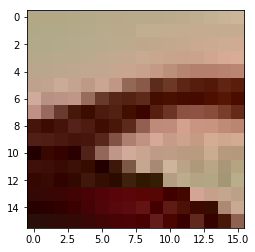

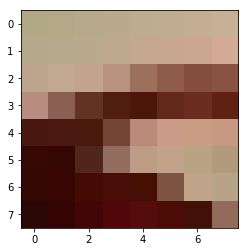

In [6]:
temp_index = np.random.randint(x_train.shape[0]) #  5429
# print(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.imshow(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.show()
plt.imshow(np.array(np.round(y_train[temp_index] * 255), dtype=np.uint8))
plt.show()

In [7]:
input_shape = (patch_size, patch_size, nb_channels)
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
encoded = MaxPool2D((2, 2), padding="same")(x)


x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="relu", padding="same")(x)  # 32
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0     

In [8]:
image_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=False, fill_mode="nearest")

In [18]:
import wandb
from wandb.keras import WandbCallback
# os.environ['WANDB_MODE'] = 'dryrun'

In [19]:
run = wandb.init(
  project="patch-desc-ae",
  config={
    "augmentation": True,
    "elus": False,
    "downsampling_output": True,
    "optimizer": "adadelta", 
    "loss": "binary_crossentropy",
    "epochs": 500 }
)

wandb: Currently logged in as: nimpy (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
%%wandb

model_version = 'patch_desc_ae_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '16_alex_3conv3mp_2020_augm_relu_dwnsmpl'

os.system('mkdir ' + base_dir + '/weights_' + model_version)
print(base_dir + '/weights_' + model_version)

# checkpointer = ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = autoencoder.fit(image_datagen.flow(x_train, y_train, batch_size),
#                 steps_per_epoch=x_train.shape[0],
                epochs=wandb.config.epochs,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
#                 validation_steps=x_validation.shape[0],
                callbacks=[WandbCallback(data_type="image", predictions=1)]  # checkpointer,
                )
autoencoder.save(base_dir + '/' + model_version + '.h5')

# autoencoder = load_model(base_dir + '/' + model_version + '.h5')

/home/niaki/Code/ImageNet/tiny-imagenet-200/weights_patch_desc_ae_20201023_15325716_alex_3conv3mp_2020_augm_relu_dwnsmpl
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4909 steps, validate for 123 steps
Epoch 1/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.6428 - val_loss: 0.6176
Epoch 2/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.6112 - val_loss: 0.6013
Epoch 3/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5999 - val_loss: 0.5919
Epoch 4/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5922 - val_loss: 0.5854
Epoch 5/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5868 - val_loss: 0.5800
Epoch 6/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5823 - val_loss: 0.5765
Epoch 7/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5787 - val_loss: 0.5727
Epoch 8/500
4909/4909 [==========================

Epoch 152/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5430 - val_loss: 0.5385
Epoch 153/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5430 - val_loss: 0.5387
Epoch 154/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5429 - val_loss: 0.5384
Epoch 155/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5428 - val_loss: 0.5387
Epoch 156/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5429 - val_loss: 0.5389
Epoch 157/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5428 - val_loss: 0.5385
Epoch 158/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5428 - val_loss: 0.5384
Epoch 159/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5427 - val_loss: 0.5384
Epoch 160/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5428 - val_loss: 0.5381
Epoch 161/500
4909/4909 [============

4909/4909 [==============================] - 53s 11ms/step - loss: 0.5408 - val_loss: 0.5363
Epoch 305/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5408 - val_loss: 0.5362
Epoch 306/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5407 - val_loss: 0.5364
Epoch 307/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5407 - val_loss: 0.5363
Epoch 308/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5407 - val_loss: 0.5363
Epoch 309/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5408 - val_loss: 0.5362
Epoch 310/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5407 - val_loss: 0.5363
Epoch 311/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5408 - val_loss: 0.5364
Epoch 312/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5407 - val_loss: 0.5362
Epoch 313/500
4909/4909 [==========================

4909/4909 [==============================] - 53s 11ms/step - loss: 0.5399 - val_loss: 0.5355
Epoch 457/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5398 - val_loss: 0.5356
Epoch 458/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5398 - val_loss: 0.5354
Epoch 459/500
4909/4909 [==============================] - 54s 11ms/step - loss: 0.5398 - val_loss: 0.5354
Epoch 460/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5399 - val_loss: 0.5350
Epoch 461/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5397 - val_loss: 0.5352
Epoch 462/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5397 - val_loss: 0.5356
Epoch 463/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5397 - val_loss: 0.5355
Epoch 464/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5397 - val_loss: 0.5352
Epoch 465/500
4909/4909 [==========================

In [21]:
wandb.save("patch_desc_ae.h5")

[]

In [23]:
run.finish()

epoch,499
loss,0.53957
val_loss,0.53508
_step,499
_runtime,26602
_timestamp,1603486560
best_val_loss,0.53461
best_epoch,476


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [22]:
history_callback.history  # why is there still no val_loss?

{'loss': [0.6427811340838695,
  0.6112030945784596,
  0.599876537229413,
  0.5921597616309742,
  0.5867754996999928,
  0.5822773794734587,
  0.5786683579565965,
  0.5752818117997072,
  0.5717876743536033,
  0.5685864390904422,
  0.5657664656414471,
  0.5638158766789553,
  0.562458957176395,
  0.561474795583908,
  0.5604123130912925,
  0.5596772892587473,
  0.5589220918140244,
  0.558221827017111,
  0.5576246947643159,
  0.5570898665068732,
  0.556586069962865,
  0.5561190933888772,
  0.5556799980036046,
  0.5553170322329187,
  0.5550017254431463,
  0.5546291223019215,
  0.5543626178196251,
  0.5540239880783251,
  0.5537526381420563,
  0.553482891468511,
  0.5532866133717479,
  0.5529637102472553,
  0.552664884039694,
  0.5525467360191039,
  0.5522096875140601,
  0.5520531316136099,
  0.5518388297683107,
  0.5516530161467444,
  0.5514115488624975,
  0.5512772907073104,
  0.5510106698956708,
  0.5508325021651507,
  0.5506907551059697,
  0.55047832347507,
  0.5503720552180356,
  0.5501668

In [ ]:
# didn't execute from here onward

predictions: 


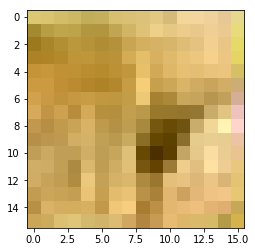

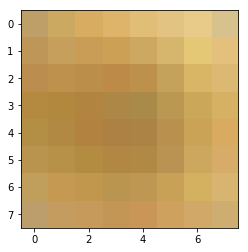

next


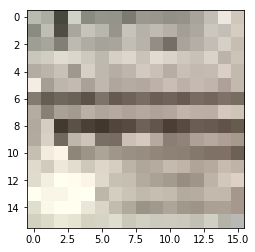

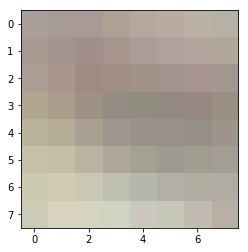

next


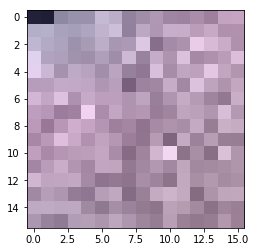

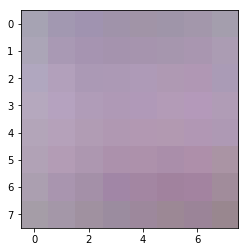

next


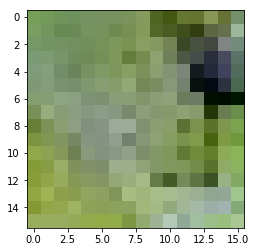

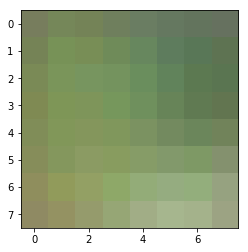

In [62]:
images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
#         img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
#         x = img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         images.append(x)
        
#         img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = autoencoder.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1, interpolation='nearest')
    plt.show()
    
    pred_1 = predictions[i].numpy()#.reshape(input_shape)
    plt.imshow(pred_1, interpolation='nearest')
    plt.show()
    
    if i > 2:
        break
    print("next")


In [63]:
encoder = Model(input_img, encoded)
for i in range(1, len(encoder.layers)):
    print(encoder.get_layer(index=i))
    encoder.get_layer(index=i).set_weights(autoencoder.get_layer(index=i).get_weights())
encoder.summary()

# encoder.save(base_dir + '/encoder' + model_version + '.h5')
encoder.save(base_dir + '/' + model_version + '__encoder.h5')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0   

In [59]:
predictions = encoder.predict_on_batch(np.array(images))

In [64]:
predictions[3]

<tf.Tensor: shape=(8, 8, 3), dtype=float32, numpy=
array([[[0.4687319 , 0.49327746, 0.36475247],
        [0.45917287, 0.5299182 , 0.34918627],
        [0.45706642, 0.5147845 , 0.34410366],
        [0.43663764, 0.49823803, 0.3672783 ],
        [0.41848794, 0.4933808 , 0.3847771 ],
        [0.39643723, 0.47318175, 0.37775475],
        [0.39109114, 0.45867485, 0.36692142],
        [0.40281394, 0.44525164, 0.37302437]],

       [[0.46041107, 0.51659435, 0.33979943],
        [0.46980157, 0.5751926 , 0.34173083],
        [0.47157863, 0.5601211 , 0.3408242 ],
        [0.43710932, 0.5458603 , 0.3502554 ],
        [0.40591332, 0.53194016, 0.37000254],
        [0.37138948, 0.48986995, 0.36715367],
        [0.35074612, 0.47033924, 0.34184617],
        [0.36991128, 0.45179874, 0.32374305]],

       [[0.48024878, 0.5416377 , 0.34048468],
        [0.4785609 , 0.58541095, 0.3535821 ],
        [0.46945688, 0.586514  , 0.372834  ],
        [0.4556866 , 0.57783   , 0.37135366],
        [0.41862264, 0.55

In [19]:
code_shape = (8, 2, 2)

images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
#     if counter > 100:
#         break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images.append(x)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2]) #patch_size, patch_size, 3
images /= 255
predictions = encoder.predict_on_batch(np.array(images))
# print("predictions: ")

# for i, im1 in enumerate(images):
#     im_1 = im1.reshape(input_shape)
#     plt.imshow(im_1, interpolation='nearest')
#     plt.show()
    
#     pred_1 = predictions[i].reshape(code_shape)
#     plt.imshow(pred_1, interpolation='nearest')
#     plt.show()
    
#     print("next")